# SARIMA model

In [28]:
import pandas as pd
import time
from itertools import combinations, product
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
import warnings
from tqdm import tqdm
from utils import get_rmse, plot_sortie_acf, timeseries_train_test_split

In [29]:
whole_df = pd.read_csv("/Users/cha/Desktop/Code/eCSpress/data/bdd_finale.csv")
whole_df['Date et heure de comptage'] = pd.to_datetime(whole_df['Date et heure de comptage'], format='%Y-%m-%d %H:%M:%S')
print("len whole_df", len(whole_df))
whole_df.columns

len whole_df 27548


Index(['Libelle', 'Date et heure de comptage', 'Débit horaire',
       'Taux d'occupation', 'Etat trafic', 'Etat arc_Barré',
       'Etat arc_Invalide', 'Jour férié', 'Jour de la semaine_0',
       'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3',
       'Jour de la semaine_4', 'Jour de la semaine_5', 'Jour de la semaine_6',
       'maxtempC', 'mintempC', 'avgtempC', 'totalSnow_cm', 'uvIndex', 'tempC',
       'windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity',
       'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC',
       'WindChillC', 'WindGustKmph', 'FeelsLikeC', 'is_day', 'paris_repsire',
       'perturbation_travaux'],
      dtype='object')

## First try on Champs Elysees

In [30]:
libelle = "AV_Champs_Elysees"
variable = 'Débit horaire'

ce_df = whole_df[whole_df["Libelle"]==libelle]
print("nb instances", len(ce_df))
ce_df = ce_df.sort_values(by='Date et heure de comptage')
ce_df = ce_df.reset_index(drop=True)
ce_df = ce_df.set_index('Date et heure de comptage')
ce_df = ce_df.asfreq('H', method= 'ffill')
ce_df['Lag_7'] = ce_df['Débit horaire'].shift(168)
ce_df.head(3)

nb instances 9186


,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,...,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Lag_7
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,1222.0,42.87945,3,0,1,1,1,0,0,...,29,10,7,8,28,8,False,False,0.0,NaN
2021-11-01 05:00:00,AV_Champs_Elysees,1033.0,44.35278,3,0,1,1,1,0,0,...,36,10,7,8,28,8,False,False,0.0,NaN
2021-11-01 06:00:00,AV_Champs_Elysees,824.0,20.16222,2,0,1,1,1,0,0,...,43,11,7,8,28,8,False,False,0.0,NaN


### Seasonal decompose

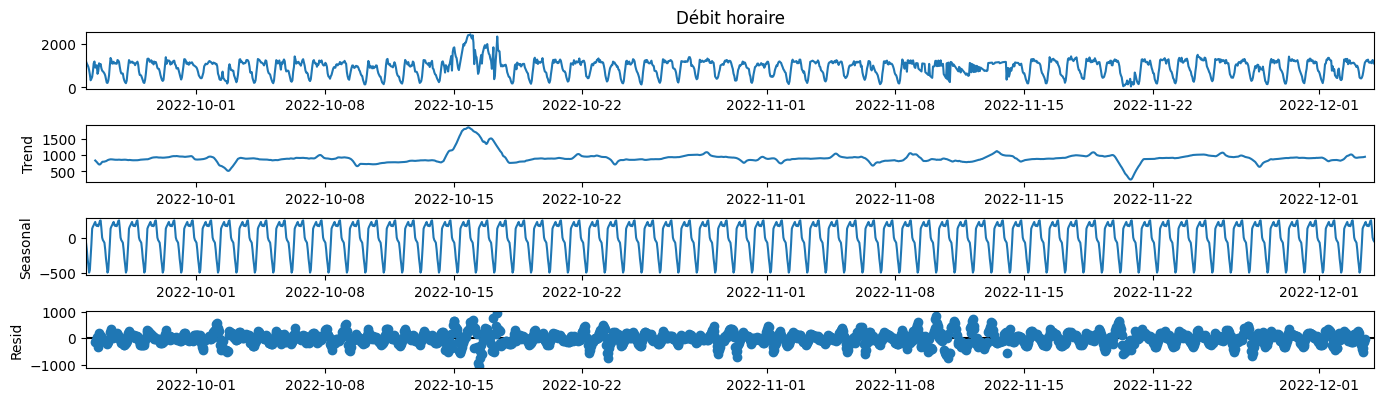

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = ce_df[variable][-7*24*10:]
decomp_x = seasonal_decompose(df, model='additive') #, period=24*7)
fig = decomp_x.plot()
fig.set_size_inches(16, 4)
plt.show()

### ACF

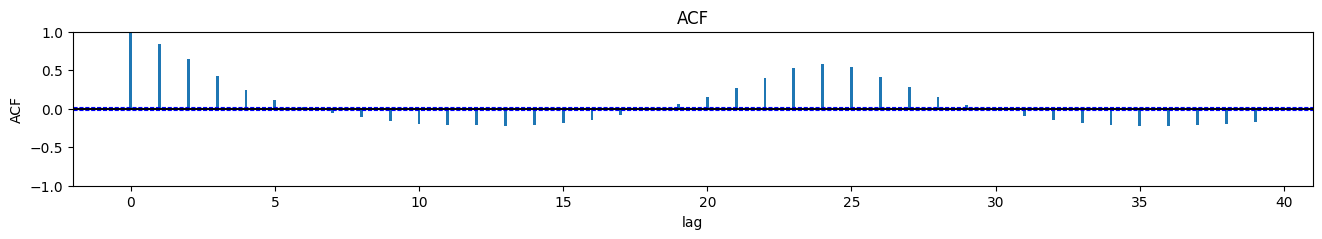

In [32]:
y = np.log(ce_df[variable])
y_len = len(y) # variable nécessaire pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y)), y_len)

### P value

In [33]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(y)
pvalue

1.485720201174954e-23

### First SARIMA model with qualitatively chosen parameters

In [16]:
# Ordres du modèle
p,q,d=1,1,1
seasonal = (1,1,1,24)

_, _, y_train, y_test = timeseries_train_test_split(X=ce_df[variable], y=ce_df[variable])
steps_ahead = len(y_test)


model = sm.tsa.statespace.SARIMAX(
    y_train, order=(p,q,d), seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False
).fit(max_iter=50, method='powell')

/Users/cha/.pyenv/versions/3.8.15/envs/datathon/lib/python3.8/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 6.405206
         Iterations: 3
         Function evaluations: 179


RMSE error : 389.13


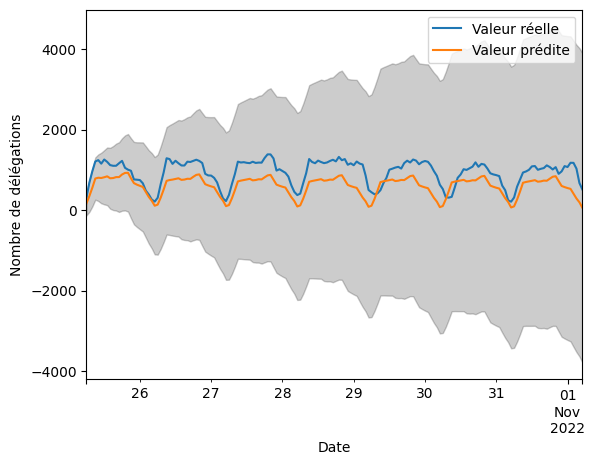

In [22]:
y_test = y_test.iloc[:steps_ahead]
pred = model.get_forecast(steps=steps_ahead)
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean
pred_mean = pred_mean.rename("Débit horaire")
RMSE = round(get_rmse(y_test, pred_mean), 2)

print(f"RMSE error : {RMSE}")

ax = y_test.plot(label='Valeur réelle')
pred_mean.plot(ax = ax, label='Valeur prédite')

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:,0],
    pred_ci.iloc[:,1],
    color='k',
    alpha=0.2
)

plt.xlabel('Date')
plt.ylabel('Nombre de délégations')
plt.legend()
plt.show()

### Class for grid search to optimize SARIMA model

In [36]:
class ForecastingSARIMA:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.steps_ahead = len(test)
        self.best_sarima_model_config = None
        self.best_sarima_fitted_model = None

    def forecast(self):
        self.getBestConfigSarima()
        self.fitBestModel()
        RMSE = self.evaluate_pred()
        return RMSE

    def getBestConfigSarima(self):
        """
        Function that returns the best configuration for a SARIMA model
        """
        p = q = range(0, 2)
        d = [0, 1]
        pdq = list(product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 24) for x in pdq]

        current_best_config = None
        current_best_aic = None
        for order in pdq:
            for seasonal_order in seasonal_pdq:
                try:
                    model = sm.tsa.statespace.SARIMAX(
                        self.train,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_invertibility=False,
                        enforce_stationarity=False
                    )

                    results = model.fit(disp=False)
                    results_aic = results.aic
                    if not current_best_aic or results_aic < current_best_aic:
                        current_best_aic = results_aic
                        current_best_config = (order, seasonal_order)
                except ValueError:
                    continue

        self.best_sarima_model_config = current_best_config


    def fitBestModel(self):
        """
        Function that returns the best SARIMA fitted model.
        """
        model = sm.tsa.statespace.SARIMAX(
            self.train,
            order = self.best_sarima_model_config[0],
            seasonal_order=self.best_sarima_model_config[1],
            enforce_invertibility=False,
            enforce_stationarity=False
        )

        self.best_sarima_fitted_model = model.fit(disp=False)


    def evaluate_pred(self):
        """
        Function that plots the SARIMA prediction with the best fitted model.
        """
        pred = self.best_sarima_fitted_model.get_forecast(steps=self.steps_ahead)
        self.test = self.test.iloc[:self.steps_ahead]

        pred_ci = pred.conf_int()
        pred_mean = pred.predicted_mean
        pred_mean = pred_mean.rename("Débit horaire")

        RMSE = round(get_rmse(self.test, pred_mean), 2)

        print(f"RMSE error : {RMSE}")

        ax = self.test.plot(label='Valeur réelle')
        pred_mean.plot(ax = ax, label='Valeur prédite')

        ax.fill_between(
            pred_ci.index,
            pred_ci.iloc[:,0],
            pred_ci.iloc[:,1],
            color='k',
            alpha=0.2
        )

        plt.xlabel('Date')
        plt.ylabel('Débit horaire')
        plt.legend()
        plt.show()

        return RMSE

### Cas pour une prédiction sur le test set (0.1% dernieres valeurs)

/Users/cha/.pyenv/versions/3.8.15/envs/datathon/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cha/.pyenv/versions/3.8.15/envs/datathon/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE error : 270.55


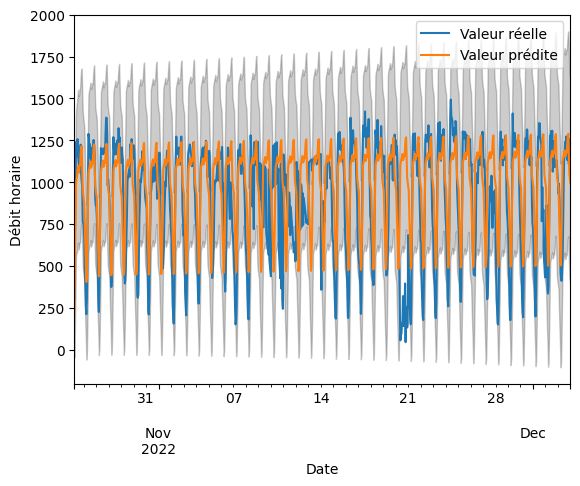

In [37]:
_, _, y_train, y_test = timeseries_train_test_split(X=ce_df[variable], y=ce_df[variable])

sarima = ForecastingSARIMA(
    train=y_train,
    test=y_test
)
RMSE = sarima.forecast()

In [38]:
sarima.best_sarima_model_config

((1, 1, 1), (1, 1, 1, 24))

### Cas pour une prédiction sur 1 semaine

/Users/cha/.pyenv/versions/3.8.15/envs/datathon/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cha/.pyenv/versions/3.8.15/envs/datathon/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE error : 186.04


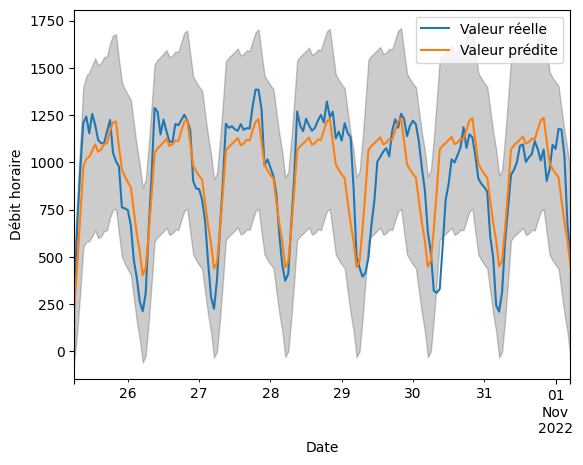

In [35]:
_, _, y_train, y_test = timeseries_train_test_split(X=ce_df[variable], y=ce_df[variable])

sarima = ForecastingSARIMA(
    train=y_train,
    test=y_test
)
RMSE = sarima.forecast()